<a href="https://colab.research.google.com/github/Oblachko-Js/vac-machine-learning/blob/main/vac_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Установка всех нужных библиотек в Google Colab
!pip install catboost pandas numpy matplotlib scikit-learn xgboost lightgbm optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


In [11]:
import numpy as np
import pandas as pd
import random
from scipy import stats
import datetime

np.random.seed(42)
random.seed(42)

N = 30000  # размер выборки

# ============================================
# БАЗОВЫЕ КОЭФФИЦИЕНТЫ И ПАРАМЕТРЫ
# ============================================

# Районы с координатами (широта, долгота) и базовыми ценами
districts = {
    "Центральный": {"coef": 1.35, "lat": 59.93, "lon": 30.32, "center_dist_km": 0.0},
    "Адмиралтейский": {"coef": 1.25, "lat": 59.92, "lon": 30.28, "center_dist_km": 1.5},
    "Петроградский": {"coef": 1.30, "lat": 59.97, "lon": 30.30, "center_dist_km": 2.0},
    "Московский": {"coef": 1.10, "lat": 59.89, "lon": 30.32, "center_dist_km": 4.0},
    "Приморский": {"coef": 1.05, "lat": 60.00, "lon": 30.15, "center_dist_km": 6.0},
    "Фрунзенский": {"coef": 0.95, "lat": 59.85, "lon": 30.38, "center_dist_km": 5.0},
    "Калининский": {"coef": 0.90, "lat": 60.00, "lon": 30.40, "center_dist_km": 7.0},
    "Невский": {"coef": 0.92, "lat": 59.93, "lon": 30.50, "center_dist_km": 8.0},
    "Василеостровский": {"coef": 1.20, "lat": 59.94, "lon": 30.25, "center_dist_km": 2.5},
    "Кировский": {"coef": 0.88, "lat": 59.88, "lon": 30.25, "center_dist_km": 6.5}
}

# Станции метро с координатами
metro_stations = {
    "Невский проспект": {"coef": 1.30, "line": 2, "lat": 59.93, "lon": 30.33},
    "Гостиный двор": {"coef": 1.28, "line": 1, "lat": 59.93, "lon": 30.33},
    "Петроградская": {"coef": 1.20, "line": 2, "lat": 59.97, "lon": 30.31},
    "Московская": {"coef": 1.10, "line": 2, "lat": 59.89, "lon": 30.32},
    "Комендантский проспект": {"coef": 1.05, "line": 5, "lat": 60.01, "lon": 30.26},
    "Проспект Ветеранов": {"coef": 0.95, "line": 1, "lat": 59.84, "lon": 30.25},
    "Ладожская": {"coef": 0.97, "line": 4, "lat": 59.93, "lon": 30.44},
    "Площадь Восстания": {"coef": 1.25, "line": 1, "lat": 59.93, "lon": 30.36},
    "Чернышевская": {"coef": 1.15, "line": 1, "lat": 59.94, "lon": 30.36},
    "Спортивная": {"coef": 1.18, "line": 5, "lat": 59.95, "lon": 30.29}
}

# Качество ремонта
renovation_coef = {
    "без ремонта": {"coef": 0.85, "year": 1995},
    "косметический": {"coef": 1.00, "year": 2005},
    "евроремонт": {"coef": 1.15, "year": 2015},
    "дизайнерский": {"coef": 1.30, "year": 2020}
}

# Мебель
furniture_coef = {
    "нет": {"coef": 0.95, "appliances": 0},
    "частично": {"coef": 1.00, "appliances": 2},
    "полностью": {"coef": 1.05, "appliances": 5}
}

# Дополнительные удобства (бинарные признаки)
amenities = {
    "balcony": {"coef": 1.02, "prob": 0.6},
    "loggia": {"coef": 1.03, "prob": 0.3},
    "separate_bathroom": {"coef": 1.01, "prob": 0.7},
    "view_to_river": {"coef": 1.04, "prob": 0.1},
    "parking": {"coef": 1.02, "prob": 0.4},
    "concierge": {"coef": 1.01, "prob": 0.2}
}

# Сезонные коэффициенты с учетом кризиса 2022-2023
season_coef = {
    1: 0.92, 2: 0.93, 3: 1.00,
    4: 1.03, 5: 1.06, 6: 1.12,
    7: 1.15, 8: 1.18,
    9: 1.12, 10: 1.07,
    11: 0.98, 12: 0.94
}

# Год постройки распределения по районам (исправленные диапазоны)
build_year_ranges = {
    "Центральный": (1890, 2023),
    "Адмиралтейский": (1900, 2023),
    "Петроградский": (1910, 2023),
    "Московский": (1960, 2023),
    "Приморский": (1990, 2023),
    "Фрунзенский": (1960, 2023),
    "Калининский": (1970, 2023),
    "Невский": (1960, 2023),
    "Василеостровский": (1930, 2023),
    "Кировский": (1950, 2023)
}

# ============================================
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# ============================================

def calculate_distance(lat1, lon1, lat2, lon2):
    """Рассчитывает расстояние между двумя точками (упрощенно)"""
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2) * 111  # примерно в км

def get_build_year(district):
    """Генерация года постройки в зависимости от района"""
    min_year, max_year = build_year_ranges[district]

    # Определяем порог для "старого фонда" - минимум из 1970 и середины диапазона
    old_threshold = min(1970, (min_year + max_year) // 2)

    # Бимодальное распределение: старый фонд и новостройки
    if random.random() < 0.3 and min_year < old_threshold:  # 30% старый фонд, если возможно
        year = np.random.randint(min_year, old_threshold)
    else:  # 70% относительно новые дома
        year = np.random.randint(max(min_year, 1970), max_year)

    return year

def calculate_age_penalty(build_year):
    """Штраф за возраст дома"""
    age = 2024 - build_year
    if age < 10:
        return 1.0
    elif age < 30:
        return 0.98
    elif age < 50:
        return 0.95
    else:
        return 0.90

def generate_metro_line_bonus(line):
    """Бонус в зависимости от линии метро"""
    line_bonuses = {1: 1.02, 2: 1.01, 3: 1.00, 4: 1.00, 5: 1.03}
    return line_bonuses.get(line, 1.0)

def generate_floor_coefficient(floor, floors_total):
    """Коэффициент в зависимости от этажа"""
    if floor == 1:
        return 0.97  # первый этаж дешевле
    elif floor == floors_total:
        return 1.03  # последний этаж дороже
    elif floors_total >= 9 and floor >= floors_total - 2:
        return 1.05  # высокие этажи в высотках
    else:
        return 1.0

# ============================================
# ГЕНЕРАЦИЯ ДАННЫХ
# ============================================

print("🔧 Генерация расширенного синтетического датасета...")
print("=" * 60)

data = []

# Координаты центра СПб
center_lat, center_lon = 59.93, 30.32

for i in range(N):
    if i % 5000 == 0:
        print(f"Сгенерировано {i:,} записей...")

    # ===== БАЗОВЫЕ ПАРАМЕТРЫ =====
    area = np.clip(np.random.normal(45, 15), 20, 100)
    rooms = np.random.choice([1, 2, 3, 4], p=[0.50, 0.35, 0.12, 0.03])

    # Распределение районов с учетом популярности
    district_probs = [0.15, 0.12, 0.10, 0.11, 0.14, 0.10, 0.09, 0.08, 0.06, 0.05]
    district = np.random.choice(list(districts.keys()), p=district_probs)

    # Этажность зависит от района
    if district in ["Центральный", "Адмиралтейский"]:
        floors_total = np.random.choice([5, 6, 7, 9], p=[0.3, 0.3, 0.2, 0.2])
    else:
        floors_total = np.random.choice([5, 9, 12, 16, 25], p=[0.2, 0.3, 0.3, 0.15, 0.05])

    floor = np.random.randint(1, floors_total + 1)

    # ===== ГЕОГРАФИЧЕСКИЕ ДАННЫЕ =====
    district_info = districts[district]

    # Генерация случайных координат в пределах района (±0.02 градуса)
    lat = district_info["lat"] + np.random.uniform(-0.02, 0.02)
    lon = district_info["lon"] + np.random.uniform(-0.02, 0.02)

    # Расстояние до центра
    center_distance = calculate_distance(lat, lon, center_lat, center_lon)

    # ===== МЕТРО =====
    # Ближайшая станция метро (случайная, но с учетом района)
    metro_candidates = list(metro_stations.keys())
    metro = np.random.choice(metro_candidates)
    metro_info = metro_stations[metro]

    # Расстояние до метро зависит от района
    if district in ["Центральный", "Адмиралтейский"]:
        metro_distance = np.clip(np.random.exponential(5), 1, 15)
    else:
        metro_distance = np.clip(np.random.exponential(8), 1, 25)

    # ===== ХАРАКТЕРИСТИКИ КВАРТИРЫ =====
    build_year = get_build_year(district)
    house_age = 2024 - build_year

    renovation = np.random.choice(list(renovation_coef.keys()),
                                  p=[0.15, 0.50, 0.30, 0.05])
    furniture = np.random.choice(list(furniture_coef.keys()),
                                 p=[0.20, 0.50, 0.30])

    month = np.random.randint(1, 13)

    # ===== ДОПОЛНИТЕЛЬНЫЕ УДОБСТВА =====
    has_balcony = 1 if random.random() < amenities["balcony"]["prob"] else 0
    has_loggia = 1 if random.random() < amenities["loggia"]["prob"] else 0
    has_separate_bathroom = 1 if random.random() < amenities["separate_bathroom"]["prob"] else 0
    has_view_to_river = 1 if random.random() < amenities["view_to_river"]["prob"] else 0
    has_parking = 1 if random.random() < amenities["parking"]["prob"] else 0
    has_concierge = 1 if random.random() < amenities["concierge"]["prob"] else 0

    # Считаем общий коэффициент удобств
    amenities_coef = 1.0
    amenities_coef *= amenities["balcony"]["coef"] if has_balcony else 1.0
    amenities_coef *= amenities["loggia"]["coef"] if has_loggia else 1.0
    amenities_coef *= amenities["separate_bathroom"]["coef"] if has_separate_bathroom else 1.0
    amenities_coef *= amenities["view_to_river"]["coef"] if has_view_to_river else 1.0
    amenities_coef *= amenities["parking"]["coef"] if has_parking else 1.0
    amenities_coef *= amenities["concierge"]["coef"] if has_concierge else 1.0

    # ===== РАСЧЕТ ЦЕНЫ =====
    # Базовая цена
    base_price_per_sqm = 900  # руб/м²
    base_price = base_price_per_sqm * area

    # Влияние комнат (нелинейная зависимость)
    if rooms == 1:
        room_coef = 1.1
    elif rooms == 2:
        room_coef = 1.25
    elif rooms == 3:
        room_coef = 1.4
    else:  # 4 комнаты
        room_coef = 1.6

    # Собираем все коэффициенты
    total_coef = (
        districts[district]["coef"]
        * metro_stations[metro]["coef"]
        * renovation_coef[renovation]["coef"]
        * furniture_coef[furniture]["coef"]
        * season_coef[month]
        * (1 - metro_distance * 0.012)  # влияние расстояния до метро
        * (1 - center_distance * 0.008)  # влияние расстояния до центра
        * calculate_age_penalty(build_year)
        * generate_metro_line_bonus(metro_stations[metro]["line"])
        * generate_floor_coefficient(floor, floors_total)
        * amenities_coef
        * room_coef
    )

    # Итоговая цена
    price = base_price * total_coef

    # Добавляем шум (гетероскедастичный - больше шума для дорогих квартир)
    noise_std = price * 0.05  # 5% шума
    noise = np.random.normal(0, noise_std)
    price = max(15000, price + noise)

    # ===== СОХРАНЕНИЕ ЗАПИСИ =====
    data.append([
        round(price, 0),            # price
        round(area, 1),             # area
        rooms,                      # rooms
        floor,                      # floor
        floors_total,               # floors_total
        district,                   # district
        metro,                      # metro_station
        round(metro_distance, 1),   # metro_distance_min
        renovation,                 # renovation_quality
        furniture,                  # furniture
        month,                      # month
        round(lat, 4),              # latitude
        round(lon, 4),              # longitude
        round(center_distance, 2),  # center_distance_km
        build_year,                 # build_year
        house_age,                  # house_age
        has_balcony,                # has_balcony
        has_loggia,                 # has_loggia
        has_separate_bathroom,      # has_separate_bathroom
        has_view_to_river,          # has_view_to_river
        has_parking,                # has_parking
        has_concierge,              # has_concierge
        metro_stations[metro]["line"],  # metro_line
        renovation_coef[renovation]["year"],  # renovation_year
        furniture_coef[furniture]["appliances"]  # appliances_count
    ])

# ============================================
# СОЗДАНИЕ DATAFRAME И СОХРАНЕНИЕ
# ============================================

columns = [
    "price", "area", "rooms", "floor", "floors_total",
    "district", "metro_station", "metro_distance_min",
    "renovation_quality", "furniture", "month",
    "latitude", "longitude", "center_distance_km",
    "build_year", "house_age",
    "has_balcony", "has_loggia", "has_separate_bathroom",
    "has_view_to_river", "has_parking", "has_concierge",
    "metro_line", "renovation_year", "appliances_count"
]

df = pd.DataFrame(data, columns=columns)

# Добавляем производные признаки
df["price_per_sqm"] = df["price"] / df["area"]
df["floor_ratio"] = df["floor"] / df["floors_total"]
df["is_new_building"] = (df["build_year"] >= 2010).astype(int)
df["is_center"] = (df["center_distance_km"] <= 3).astype(int)
df["is_high_floor"] = ((df["floor"] / df["floors_total"]) > 0.7).astype(int)
df["amenities_count"] = (df["has_balcony"] + df["has_loggia"] +
                         df["has_separate_bathroom"] + df["has_view_to_river"] +
                         df["has_parking"] + df["has_concierge"])

# Добавляем сезонные признаки
df["is_summer"] = df["month"].isin([6, 7, 8]).astype(int)
df["is_winter"] = df["month"].isin([12, 1, 2]).astype(int)

# Сохраняем в CSV
df.to_csv("spb_rent_extended.csv", index=False, encoding='utf-8')

# ============================================
# ВЫВОД СТАТИСТИКИ
# ============================================

print("\n" + "=" * 60)
print("✅ СИНТЕТИЧЕСКИЙ ДАТАСЕТ УСПЕШНО СОЗДАН")
print("=" * 60)

print(f"\n📊 ОСНОВНЫЕ ХАРАКТЕРИСТИКИ:")
print(f"   • Размер выборки: {len(df):,} объектов")
print(f"   • Количество признаков: {df.shape[1]}")
print(f"   • Диапазон цен: {df['price'].min():,.0f} - {df['price'].max():,.0f} руб.")
print(f"   • Средняя цена: {df['price'].mean():,.0f} руб.")
print(f"   • Средняя цена за м²: {df['price_per_sqm'].mean():,.0f} руб./м²")

print(f"\n🏙️  РАСПРЕДЕЛЕНИЕ ПО РАЙОНАМ:")
district_counts = df['district'].value_counts()
for district, count in district_counts.items():
    percentage = count / len(df) * 100
    avg_price = df[df['district'] == district]['price'].mean()
    print(f"   • {district:<20} {count:>5} ({percentage:.1f}%) | {avg_price:,.0f} руб.")

print(f"\n📈 СТАТИСТИКА ЦЕН:")
price_stats = df['price'].describe()
for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    value = price_stats[stat]
    print(f"   • {stat:>5}: {value:,.0f} руб.")

print(f"\n🌍 ГЕОГРАФИЧЕСКИЕ ХАРАКТЕРИСТИКИ:")
print(f"   • Среднее расстояние до центра: {df['center_distance_km'].mean():.1f} км")
print(f"   • Среднее расстояние до метро: {df['metro_distance_min'].mean():.1f} мин")

print(f"\n🏠 ХАРАКТЕРИСТИКИ ЖИЛЬЯ:")
print(f"   • Средняя площадь: {df['area'].mean():.1f} м²")
print(f"   • Средний год постройки: {df['build_year'].mean():.0f}")
print(f"   • Новостройки (после 2010): {df['is_new_building'].sum():,} ({df['is_new_building'].mean()*100:.1f}%)")

# Корреляции с ценой
print(f"\n🔗 КОРРЕЛЯЦИЯ С ЦЕНОВОЙ ПЕРЕМЕННОЙ:")
# Выбираем только числовые признаки для корреляции
numeric_features = ['area', 'rooms', 'metro_distance_min', 'center_distance_km',
                   'house_age', 'amenities_count', 'price_per_sqm', 'floor_ratio']
correlations = df[numeric_features].corrwith(df['price'])

for feature, corr in correlations.items():
    correlation_strength = ""
    if abs(corr) > 0.7:
        correlation_strength = "🔥 ОЧЕНЬ СИЛЬНАЯ"
    elif abs(corr) > 0.5:
        correlation_strength = "🔴 СИЛЬНАЯ"
    elif abs(corr) > 0.3:
        correlation_strength = "🟠 УМЕРЕННАЯ"
    elif abs(corr) > 0.1:
        correlation_strength = "🟡 СЛАБАЯ"
    else:
        correlation_strength = "⚪ ОЧЕНЬ СЛАБАЯ"

    print(f"   • {feature:<25} {corr:>7.3f} ({correlation_strength})")

print(f"\n💾 Файл сохранен: 'spb_rent_extended.csv'")
print(f"   Готов для использования в машинном обучении!")
print("=" * 60)

# Показываем первые строки
print("\n📋 ПЕРВЫЕ 5 СТРОК ДАТАСЕТА:")
print(df.head().to_string())

# ============================================
# ДОПОЛНИТЕЛЬНАЯ АНАЛИТИКА
# ============================================

print("\n📊 ДОПОЛНИТЕЛЬНАЯ АНАЛИТИКА:")
print("-" * 50)

# Анализ по комнатам
print(f"\n🏠 АНАЛИЗ ПО КОЛИЧЕСТВУ КОМНАТ:")
for rooms in sorted(df['rooms'].unique()):
    subset = df[df['rooms'] == rooms]
    avg_price = subset['price'].mean()
    avg_area = subset['area'].mean()
    avg_price_sqm = subset['price_per_sqm'].mean()
    count = len(subset)
    print(f"   • {rooms} комн.: {count:>5} объектов | {avg_price:,.0f} руб. | {avg_area:.1f} м² | {avg_price_sqm:,.0f} руб./м²")

# Анализ по качеству ремонта
print(f"\n🎨 АНАЛИЗ ПО КАЧЕСТВУ РЕМОНТА:")
for renovation in renovation_coef.keys():
    subset = df[df['renovation_quality'] == renovation]
    if len(subset) > 0:
        avg_price = subset['price'].mean()
        count = len(subset)
        print(f"   • {renovation:<15} {count:>5} объектов | {avg_price:,.0f} руб.")

# Анализ по сезонам
print(f"\n🌤️  АНАЛИЗ ПО СЕЗОНАМ:")
seasons = {
    "Зима (дек-фев)": [12, 1, 2],
    "Весна (мар-май)": [3, 4, 5],
    "Лето (июн-авг)": [6, 7, 8],
    "Осень (сен-ноя)": [9, 10, 11]
}

for season_name, months in seasons.items():
    subset = df[df['month'].isin(months)]
    avg_price = subset['price'].mean()
    count = len(subset)
    print(f"   • {season_name:<20} {count:>5} объектов | {avg_price:,.0f} руб.")

# Анализ удобств
print(f"\n🏅 АНАЛИЗ УДОБСТВ:")
print(f"   • Квартиры с балконом: {df['has_balcony'].sum():,} ({df['has_balcony'].mean()*100:.1f}%)")
print(f"   • Квартиры с лоджией: {df['has_loggia'].sum():,} ({df['has_loggia'].mean()*100:.1f}%)")
print(f"   • Квартиры с парковкой: {df['has_parking'].sum():,} ({df['has_parking'].mean()*100:.1f}%)")
print(f"   • Квартиры с консьержем: {df['has_concierge'].sum():,} ({df['has_concierge'].mean()*100:.1f}%)")

# ============================================
# СОХРАНЕНИЕ ОПИСАНИЯ ПРИЗНАКОВ (ИСПРАВЛЕННОЕ)
# ============================================

# Правильно определяем все признаки и их описания
all_features = [
    "price", "area", "rooms", "floor", "floors_total",
    "district", "metro_station", "metro_distance_min",
    "renovation_quality", "furniture", "month",
    "latitude", "longitude", "center_distance_km",
    "build_year", "house_age",
    "has_balcony", "has_loggia", "has_separate_bathroom",
    "has_view_to_river", "has_parking", "has_concierge",
    "metro_line", "renovation_year", "appliances_count",
    "price_per_sqm", "floor_ratio", "is_new_building",
    "is_center", "is_high_floor", "amenities_count",
    "is_summer", "is_winter"
]

feature_types = [
    'target', 'numeric', 'numeric', 'numeric', 'numeric',
    'categorical', 'categorical', 'numeric',
    'categorical', 'categorical', 'numeric',
    'numeric', 'numeric', 'numeric',
    'numeric', 'numeric',
    'binary', 'binary', 'binary',
    'binary', 'binary', 'binary',
    'numeric', 'numeric', 'numeric',
    'numeric', 'numeric', 'binary',
    'binary', 'binary', 'numeric',
    'binary', 'binary'
]

feature_descriptions = [
    'Цена аренды в рублях',
    'Площадь квартиры в м²',
    'Количество комнат',
    'Этаж',
    'Всего этажей в доме',
    'Район Санкт-Петербурга',
    'Ближайшая станция метро',
    'Время до метро в минутах',
    'Качество ремонта',
    'Наличие мебели',
    'Месяц сдачи (1-12)',
    'Широта',
    'Долгота',
    'Расстояние до центра в км',
    'Год постройки дома',
    'Возраст дома в годах',
    'Наличие балкона (0/1)',
    'Наличие лоджии (0/1)',
    'Раздельный санузел (0/1)',
    'Вид на реку (0/1)',
    'Наличие парковки (0/1)',
    'Наличие консьержа (0/1)',
    'Линия метро (1-5)',
    'Год последнего ремонта',
    'Количество бытовой техники',
    'Цена за квадратный метр',
    'Относительный этаж (floor/floors_total)',
    'Новостройка (1 если build_year >= 2010)',
    'Центральный район (1 если center_distance_km <= 3)',
    'Высокий этаж (1 если floor_ratio > 0.7)',
    'Общее количество удобств',
    'Летний сезон (1 если июнь-август)',
    'Зимний сезон (1 если декабрь-февраль)'
]

# Проверяем, что все массивы одинаковой длины
print(f"Количество признаков: {len(all_features)}")
print(f"Количество типов: {len(feature_types)}")
print(f"Количество описаний: {len(feature_descriptions)}")

if len(all_features) == len(feature_types) == len(feature_descriptions):
    # Создаем DataFrame с описанием признаков
    feature_desc_df = pd.DataFrame({
        'feature': all_features,
        'type': feature_types,
        'description': feature_descriptions
    })

    feature_desc_df.to_csv('feature_descriptions.csv', index=False, encoding='utf-8')
    print(f"\n📝 Описание признаков сохранено в 'feature_descriptions.csv'")
else:
    print("Ошибка: массивы разной длины!")
    print(f"Признаки: {len(all_features)}, Типы: {len(feature_types)}, Описания: {len(feature_descriptions)}")

# ============================================
# СОХРАНЕНИЕ СТАТИСТИКИ В ОТДЕЛЬНЫЙ ФАЙЛ
# ============================================

# Сохраняем основную статистику
stats_summary = {
    'metric': [
        'total_records', 'total_features', 'min_price', 'max_price', 'mean_price',
        'median_price', 'std_price', 'mean_area', 'mean_build_year',
        'new_buildings_pct', 'center_apartments_pct', 'summer_listings_pct'
    ],
    'value': [
        len(df), df.shape[1], df['price'].min(), df['price'].max(), df['price'].mean(),
        df['price'].median(), df['price'].std(), df['area'].mean(), df['build_year'].mean(),
        df['is_new_building'].mean()*100, df['is_center'].mean()*100, df['is_summer'].mean()*100
    ]
}

stats_df = pd.DataFrame(stats_summary)
stats_df.to_csv('dataset_statistics.csv', index=False, encoding='utf-8')

print(f"\n📈 Основная статистика сохранена в 'dataset_statistics.csv'")
print("\n" + "=" * 60)
print("🎉 ВСЁ ГОТОВО! ДАТАСЕТ МОЖНО ИСПОЛЬЗОВАТЬ ДЛЯ МАШИННОГО ОБУЧЕНИЯ")
print("=" * 60)

🔧 Генерация расширенного синтетического датасета...
Сгенерировано 0 записей...
Сгенерировано 5,000 записей...
Сгенерировано 10,000 записей...
Сгенерировано 15,000 записей...
Сгенерировано 20,000 записей...
Сгенерировано 25,000 записей...

✅ СИНТЕТИЧЕСКИЙ ДАТАСЕТ УСПЕШНО СОЗДАН

📊 ОСНОВНЫЕ ХАРАКТЕРИСТИКИ:
   • Размер выборки: 30,000 объектов
   • Количество признаков: 33
   • Диапазон цен: 15,000 - 241,454 руб.
   • Средняя цена: 59,060 руб.
   • Средняя цена за м²: 1,302 руб./м²

🏙️  РАСПРЕДЕЛЕНИЕ ПО РАЙОНАМ:
   • Центральный           4472 (14.9%) | 77,288 руб.
   • Приморский            4156 (13.9%) | 50,517 руб.
   • Адмиралтейский        3704 (12.3%) | 69,200 руб.
   • Московский            3275 (10.9%) | 59,416 руб.
   • Петроградский         2982 (9.9%) | 70,005 руб.
   • Фрунзенский           2968 (9.9%) | 48,172 руб.
   • Калининский           2688 (9.0%) | 46,295 руб.
   • Невский               2420 (8.1%) | 43,840 руб.
   • Василеостровский      1833 (6.1%) | 62,967 руб.
   •

🚀 ПОЛНЫЙ АНАЛИЗ И МОДЕЛИРОВАНИЕ ЦЕН АРЕНДЫ КВАРТИР

📥 1. Загрузка данных...
   Размер выборки: 30,000 объектов
   Количество признаков: 33

📊 Типы данных:
int64      21
float64     8
object      4
Name: count, dtype: int64

🔍 Пропущенные значения:
Empty DataFrame
Columns: [Количество, Процент]
Index: []

🎯 2. Определение признаков...
   Всего признаков: 32
   • Числовые: 17
   • Категориальные (OneHot): 2
   • Категориальные (Ordinal): 2
   • Бинарные: 11

🔧 3. Предобработка данных...

📊 4. Разделение данных...
   Обучающая выборка: 24,000 объектов
   Тестовая выборка: 6,000 объектов
   Количество признаков: 32

🤖 5. Определение моделей...

🏋️  6. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ

════════════════════════════════════════════════════════════════════════════════════════════════════
Модель                    | MAE, руб.    | RMSE, руб.   | R²       | Время, сек | Описание
════════════════════════════════════════════════════════════════════════════════════════════════════
Linear Regression       

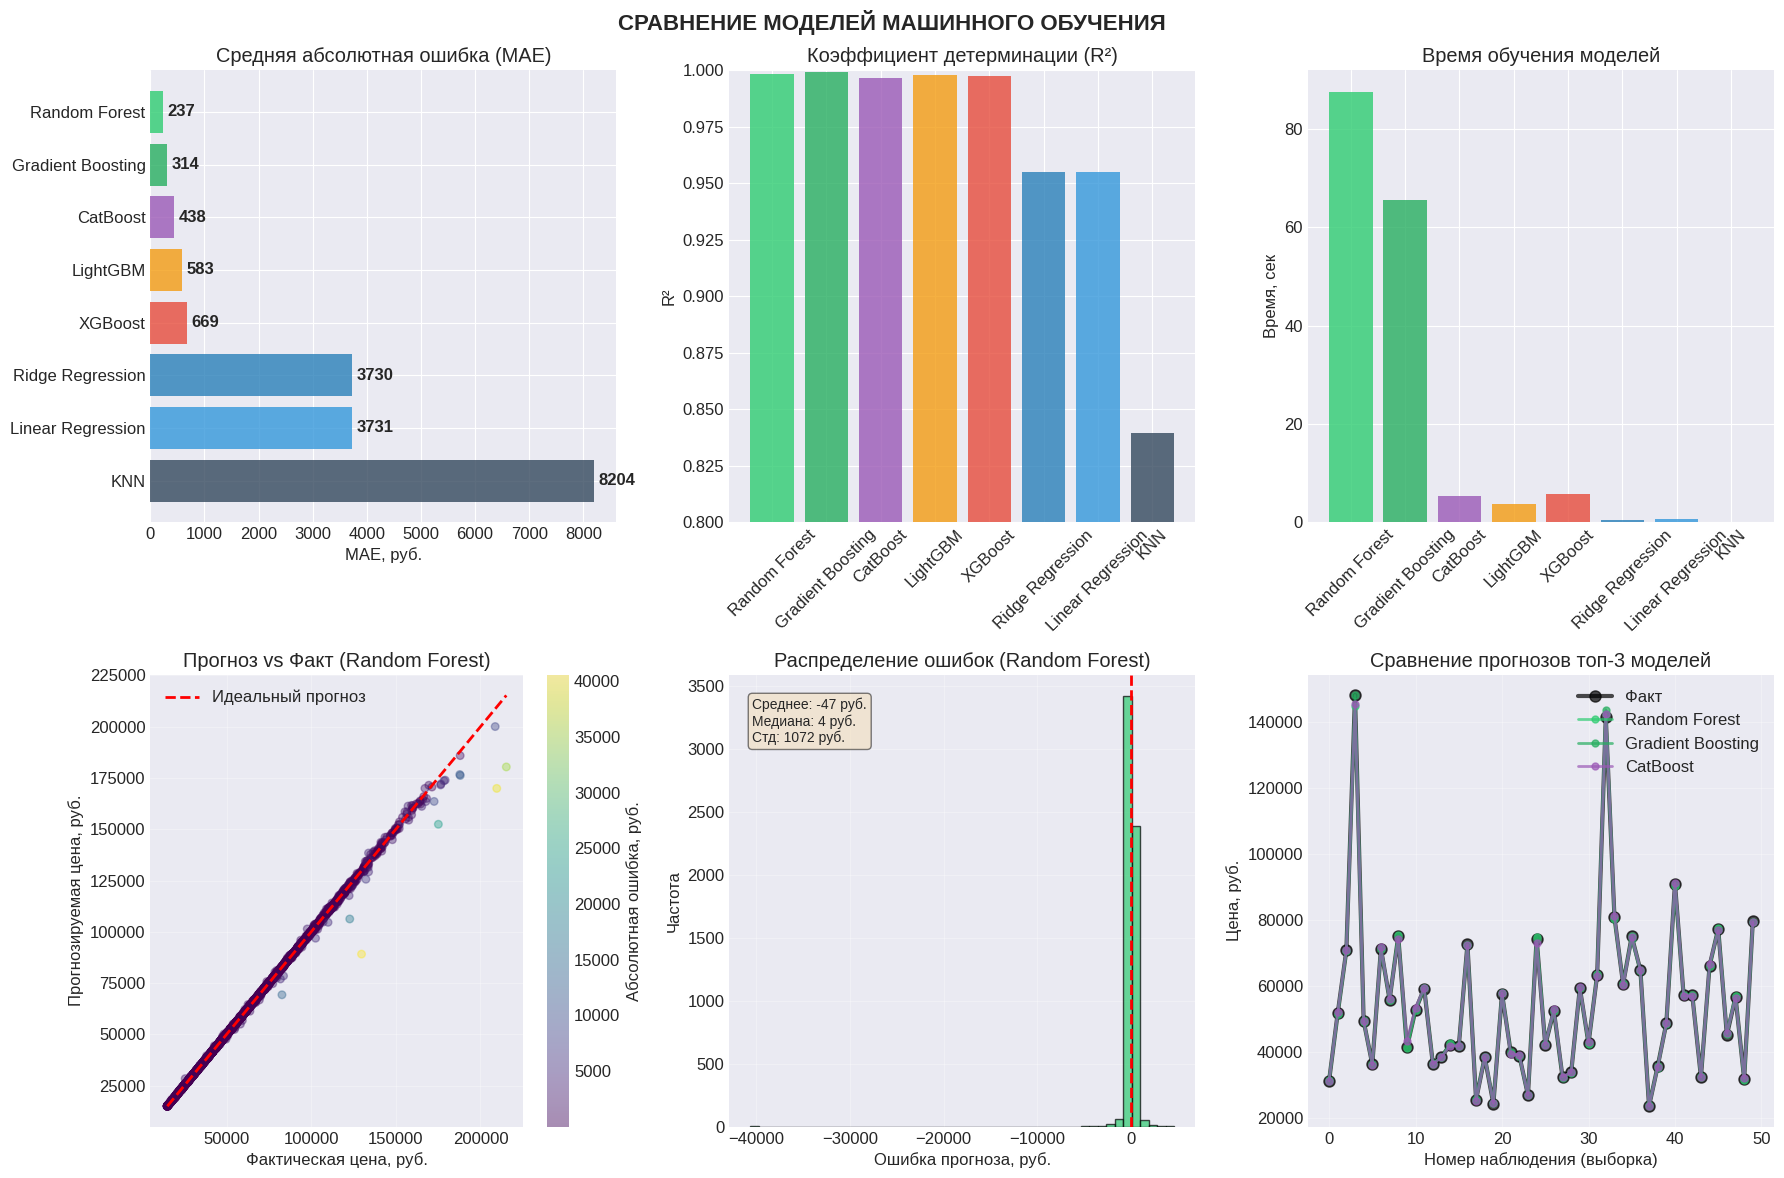


📊 Дополнительная визуализация...


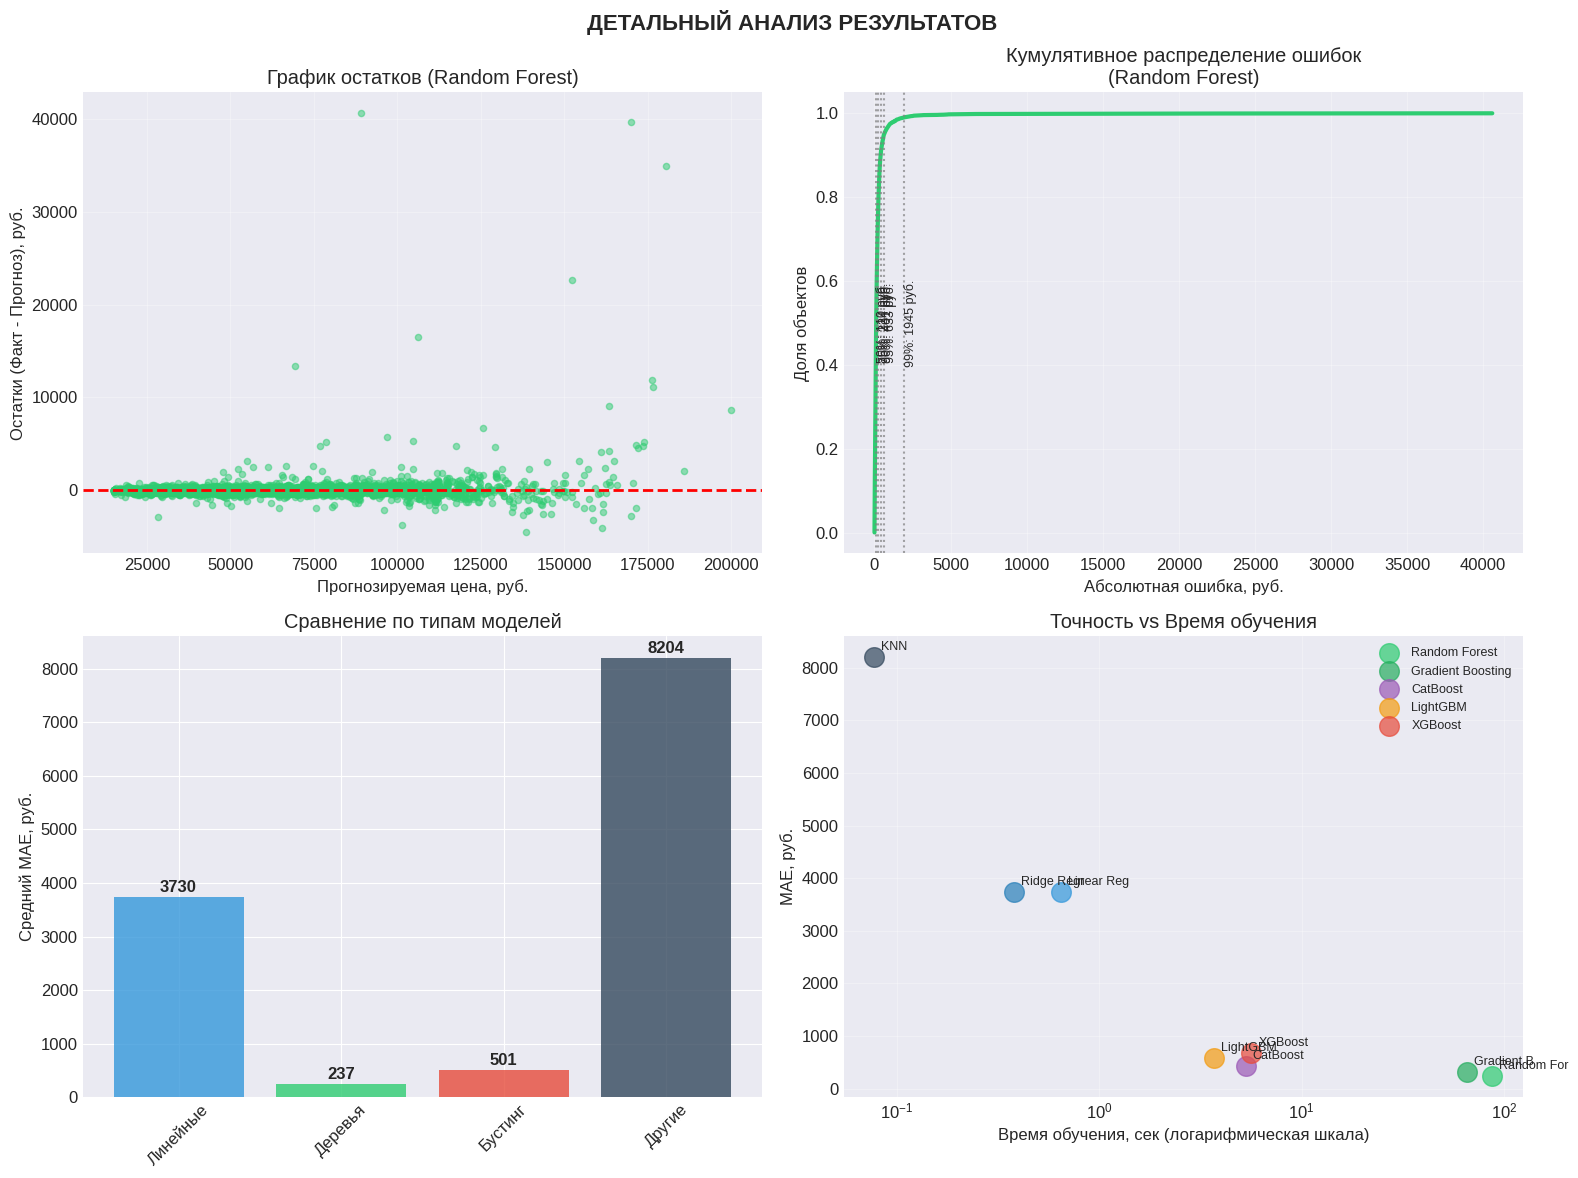


🔍 9. Анализ важности признаков...

📊 Топ-20 важнейших признаков для модели Random Forest:
--------------------------------------------------------------------------------
 1. area                                                         0.5071 (50.7%)
15. price_per_sqm                                                0.4923 (49.2%)
 9. center_distance_km                                           0.0001 (0.0%)
16. floor_ratio                                                  0.0001 (0.0%)
 5. metro_distance_min                                           0.0001 (0.0%)
 7. latitude                                                     0.0001 (0.0%)
 8. longitude                                                    0.0001 (0.0%)
 6. month                                                        0.0000 (0.0%)
 3. floor                                                        0.0000 (0.0%)
11. house_age                                                    0.0000 (0.0%)
10. build_year                      

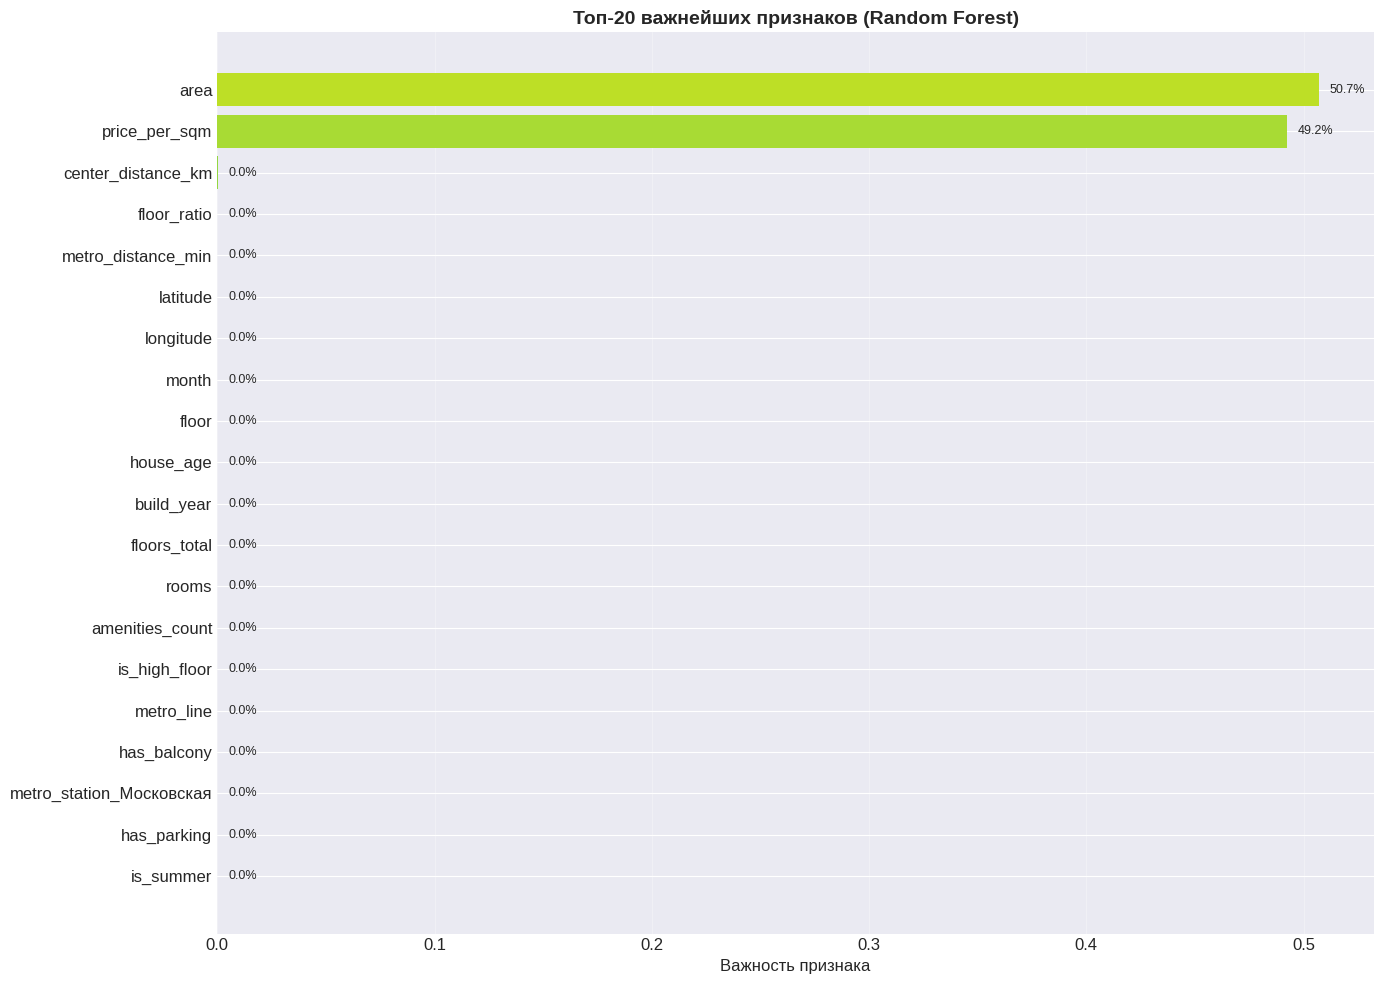


📈 Анализ влияния топ-5 признаков на цену:
------------------------------------------------------------

🔹 area:
   • Корреляция с ценой: 0.703
   • Средняя цена за м²: 1303 руб.

🔹 price_per_sqm:
   • Корреляция с ценой: 0.684
   • Среднее значение: 1302 руб./м²
   • Диапазон: 430 - 3980 руб./м²

🔹 center_distance_km:
   • Корреляция с ценой: -0.359

🔹 floor_ratio:
   • Корреляция с ценой: 0.053

🔹 metro_distance_min:
   • Корреляция с ценой: -0.227

🤝 10. Создание ансамблевой модели...
   Используем для ансамбля: Random Forest, Gradient Boosting, CatBoost
   Обучение ансамблевой модели...
   Ансамбль обучен за 450.53 сек
   • MAE: 294 руб.
   • R²: 0.9991
   • Улучшение относительно Random Forest: -24.1%

📋 10. ФИНАЛЬНЫЙ ОТЧЕТ

═════════════════════════════════════════════════════════════════════════════════════
Модель                    | MAE, руб.    | R²       | Улучшение  | Время, сек
═════════════════════════════════════════════════════════════════════════════════════
Random For

In [15]:
# ============================================
# ПОЛНЫЙ КОД МАШИННОГО ОБУЧЕНИЯ С УЛУЧШЕННЫМ ДАТАСЕТОМ
# ============================================

# Импорт всех библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

# Настройка стилей
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

# Импорт из sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Импорт моделей градиентного бустинга
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Для оптимизации гиперпараметров
import optuna

print("=" * 70)
print("🚀 ПОЛНЫЙ АНАЛИЗ И МОДЕЛИРОВАНИЕ ЦЕН АРЕНДЫ КВАРТИР")
print("=" * 70)

# ============================================
# 1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ
# ============================================
print("\n📥 1. Загрузка данных...")
df = pd.read_csv("spb_rent_extended.csv")

print(f"   Размер выборки: {len(df):,} объектов")
print(f"   Количество признаков: {df.shape[1]}")

# Проверяем типы данных
print("\n📊 Типы данных:")
print(df.dtypes.value_counts())

# Проверяем пропущенные значения
print("\n🔍 Пропущенные значения:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Количество': missing_values,
    'Процент': missing_percentage
})
print(missing_df[missing_df['Количество'] > 0])

# ============================================
# 2. ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ
# ============================================
print("\n🎯 2. Определение признаков...")

TARGET = "price"

# Числовые признаки
NUM_FEATURES = [
    "area", "rooms", "floor", "floors_total",
    "metro_distance_min", "month", "latitude", "longitude",
    "center_distance_km", "build_year", "house_age",
    "metro_line", "renovation_year", "appliances_count",
    "price_per_sqm", "floor_ratio", "amenities_count"
]

# Категориальные признаки (для OneHotEncoding)
CAT_FEATURES_ONEHOT = [
    "district", "metro_station"
]

# Категориальные признаки (для OrdinalEncoding)
CAT_FEATURES_ORDINAL = [
    "renovation_quality", "furniture"
]

# Бинарные признаки (уже закодированы 0/1)
BINARY_FEATURES = [
    "has_balcony", "has_loggia", "has_separate_bathroom",
    "has_view_to_river", "has_parking", "has_concierge",
    "is_new_building", "is_center", "is_high_floor",
    "is_summer", "is_winter"
]

# Все признаки
ALL_FEATURES = NUM_FEATURES + CAT_FEATURES_ONEHOT + CAT_FEATURES_ORDINAL + BINARY_FEATURES

print(f"   Всего признаков: {len(ALL_FEATURES)}")
print(f"   • Числовые: {len(NUM_FEATURES)}")
print(f"   • Категориальные (OneHot): {len(CAT_FEATURES_ONEHOT)}")
print(f"   • Категориальные (Ordinal): {len(CAT_FEATURES_ORDINAL)}")
print(f"   • Бинарные: {len(BINARY_FEATURES)}")

# ============================================
# 3. ПРЕДОБРАБОТКА ДАННЫХ
# ============================================
print("\n🔧 3. Предобработка данных...")

# Определяем порядок для OrdinalEncoding
renovation_order = ["без ремонта", "косметический", "евроремонт", "дизайнерский"]
furniture_order = ["нет", "частично", "полностью"]

# Создаем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_FEATURES_ONEHOT),
        ("cat_ordinal", OrdinalEncoder(categories=[renovation_order, furniture_order]), CAT_FEATURES_ORDINAL),
        ("binary", "passthrough", BINARY_FEATURES)
    ]
)

# ============================================
# 4. РАЗДЕЛЕНИЕ ДАННЫХ
# ============================================
print("\n📊 4. Разделение данных...")

X = df[ALL_FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"   Обучающая выборка: {X_train.shape[0]:,} объектов")
print(f"   Тестовая выборка: {X_test.shape[0]:,} объектов")
print(f"   Количество признаков: {X_train.shape[1]}")

# ============================================
# 5. ОПРЕДЕЛЕНИЕ МОДЕЛЕЙ
# ============================================
print("\n🤖 5. Определение моделей...")

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "color": "#3498db",
        "description": "Базовая линейная модель"
    },

    "Ridge Regression": {
        "model": Ridge(alpha=1.0, random_state=42),
        "color": "#2980b9",
        "description": "Линейная модель с L2 регуляризацией"
    },

    "Random Forest": {
        "model": RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        "color": "#2ecc71",
        "description": "Ансамбль решающих деревьев"
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        ),
        "color": "#27ae60",
        "description": "Градиентный бустинг от sklearn"
    },

    "XGBoost": {
        "model": XGBRegressor(
            n_estimators=400,
            max_depth=7,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            enable_categorical=False
        ),
        "color": "#e74c3c",
        "description": "Экстремальный градиентный бустинг"
    },

    "LightGBM": {
        "model": LGBMRegressor(
            n_estimators=400,
            max_depth=7,
            learning_rate=0.05,
            num_leaves=31,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=5,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "color": "#f39c12",
        "description": "Легкий градиентный бустинг"
    },

    "CatBoost": {
        "model": CatBoostRegressor(
            iterations=500,
            depth=7,
            learning_rate=0.05,
            l2_leaf_reg=3,
            border_count=128,
            loss_function="MAE",
            verbose=False,
            random_seed=42,
            thread_count=-1
        ),
        "color": "#9b59b6",
        "description": "Бустинг с категориальными признаками"
    },

    "KNN": {
        "model": KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
        "color": "#34495e",
        "description": "Метод k-ближайших соседей"
    }
}

# ============================================
# 6. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ
# ============================================
print("\n" + "=" * 70)
print("🏋️  6. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ")
print("=" * 70)

results = []
training_times = []

print("\n" + "═" * 100)
print(f"{'Модель':<25} | {'MAE, руб.':<12} | {'RMSE, руб.':<12} | {'R²':<8} | {'Время, сек':<10} | {'Описание'}")
print("═" * 100)

for name, config in models.items():
    model = config["model"]
    color = config["color"]
    description = config["description"]

    # Создание pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ]
    )

    # Обучение модели с замером времени
    start_time = time()
    pipeline.fit(X_train, y_train)
    training_time = time() - start_time
    training_times.append(training_time)

    # Предсказания
    preds = pipeline.predict(X_test)

    # Метрики
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    # Кросс-валидация
    cv_scores = cross_val_score(pipeline, X_train, y_train,
                               cv=3, scoring='r2', n_jobs=-1)
    cv_r2_mean = cv_scores.mean()
    cv_r2_std = cv_scores.std()

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "CV_R2_mean": cv_r2_mean,
        "CV_R2_std": cv_r2_std,
        "Time": training_time,
        "Color": color,
        "Description": description,
        "Pipeline": pipeline,
        "Predictions": preds
    })

    # Красивый вывод
    print(f"{name:<25} | {mae:<12.0f} | {rmse:<12.0f} | {r2:<8.3f} | {training_time:<10.2f} | {description}")

print("═" * 100)

# ============================================
# 7. АНАЛИЗ РЕЗУЛЬТАТОВ
# ============================================
print("\n📊 7. Анализ результатов...")

results_df = pd.DataFrame(results).sort_values("MAE")
best_result = results_df.iloc[0]
worst_result = results_df.iloc[-1]

print("\n" + "=" * 70)
print("🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ")
print("=" * 70)

# Сортируем по MAE (лучшие сверху)
sorted_results = results_df.sort_values("MAE")

print("\n" + "═" * 85)
print(f"{'Модель':<20} | {'MAE':<10} | {'R²':<8} | {'CV R²':<10} | {'Время':<8}")
print("═" * 85)

for _, row in sorted_results.iterrows():
    print(f"{row['Model']:<20} | {row['MAE']:<10.0f} | {row['R2']:<8.3f} | {row['CV_R2_mean']:.3f}±{row['CV_R2_std']:.3f} | {row['Time']:<8.2f}")

print("═" * 85)

print(f"\n🚀 ЛУЧШАЯ МОДЕЛЬ: {best_result['Model']}")
print(f"   • MAE: {best_result['MAE']:.0f} руб. ({best_result['MAE']/y.mean()*100:.1f}% от средней цены)")
print(f"   • R²: {best_result['R2']:.4f}")
print(f"   • RMSE: {best_result['RMSE']:.0f} руб.")
print(f"   • Время обучения: {best_result['Time']:.2f} сек")

print(f"\n⚠️  ХУДШАЯ МОДЕЛЬ: {worst_result['Model']}")
print(f"   • MAE: {worst_result['MAE']:.0f} руб.")
print(f"   • R²: {worst_result['R2']:.4f}")

# ============================================
# 8. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# ============================================
print("\n📈 8. Визуализация результатов...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('СРАВНЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ', fontsize=16, fontweight='bold')

# 8.1 Сравнение MAE
ax1 = axes[0, 0]
models_sorted = results_df.sort_values("MAE", ascending=True)
bars = ax1.barh(models_sorted["Model"], models_sorted["MAE"],
                color=models_sorted["Color"], alpha=0.8)
ax1.set_xlabel('MAE, руб.')
ax1.set_title('Средняя абсолютная ошибка (MAE)')
ax1.invert_yaxis()

# Добавление значений
for bar, value in zip(bars, models_sorted["MAE"]):
    ax1.text(value + max(models_sorted["MAE"])*0.01, bar.get_y() + bar.get_height()/2,
             f'{value:.0f}', va='center', fontweight='bold')

# 8.2 Сравнение R²
ax2 = axes[0, 1]
bars2 = ax2.bar(models_sorted["Model"], models_sorted["R2"],
                color=models_sorted["Color"], alpha=0.8)
ax2.set_ylabel('R²')
ax2.set_title('Коэффициент детерминации (R²)')
ax2.set_ylim(0.8, 1.0)
ax2.tick_params(axis='x', rotation=45)

# 8.3 Время обучения
ax3 = axes[0, 2]
bars3 = ax3.bar(models_sorted["Model"], models_sorted["Time"],
                color=models_sorted["Color"], alpha=0.8)
ax3.set_ylabel('Время, сек')
ax3.set_title('Время обучения моделей')
ax3.tick_params(axis='x', rotation=45)

# 8.4 Прогноз vs Факт для лучшей модели
ax4 = axes[1, 0]
best_pipeline = best_result["Pipeline"]
best_preds = best_result["Predictions"]

# Вычисляем ошибки для цветового кодирования
errors = abs(best_preds - y_test)

# Используем только параметр 'c' для цвета
scatter = ax4.scatter(y_test, best_preds, alpha=0.4,
                     s=30, c=errors, cmap='viridis')

# Линия идеального прогноза
ax4.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Идеальный прогноз')
ax4.set_xlabel('Фактическая цена, руб.')
ax4.set_ylabel('Прогнозируемая цена, руб.')
ax4.set_title(f'Прогноз vs Факт ({best_result["Model"]})')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Добавляем цветовую шкалу для ошибок
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Абсолютная ошибка, руб.')

# 8.5 Распределение ошибок лучшей модели
ax5 = axes[1, 1]
errors_dist = best_preds - y_test
ax5.hist(errors_dist, bins=50, color=best_result["Color"],
         alpha=0.7, edgecolor='black')
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Ошибка прогноза, руб.')
ax5.set_ylabel('Частота')
ax5.set_title(f'Распределение ошибок ({best_result["Model"]})')
ax5.grid(True, alpha=0.3)

# Статистика ошибок
mean_error = errors_dist.mean()
std_error = errors_dist.std()
median_error = np.median(errors_dist)
ax5.text(0.05, 0.95,
         f'Среднее: {mean_error:.0f} руб.\n'
         f'Медиана: {median_error:.0f} руб.\n'
         f'Стд: {std_error:.0f} руб.',
         transform=ax5.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 8.6 Сравнение нескольких моделей
ax6 = axes[1, 2]
sample_idx = np.random.choice(len(y_test), 50, replace=False)
sample_idx = np.sort(sample_idx)

ax6.plot(y_test.values[sample_idx], 'o-', label='Факт',
         linewidth=3, markersize=8, color='black', alpha=0.7)

# Показываем топ-3 модели
top_models = results_df.sort_values("MAE").head(3)
for i, (_, result) in enumerate(top_models.iterrows()):
    ax6.plot(result["Predictions"][sample_idx], 'o-',
             label=result["Model"], color=result["Color"],
             alpha=0.7, linewidth=2, markersize=5)

ax6.set_xlabel('Номер наблюдения (выборка)')
ax6.set_ylabel('Цена, руб.')
ax6.set_title('Сравнение прогнозов топ-3 моделей')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ
# ============================================

# Создаем дополнительные графики
print("\n📊 Дополнительная визуализация...")

fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ', fontsize=16, fontweight='bold')

# 1. График остатков для лучшей модели
ax1 = axes2[0, 0]
residuals = y_test - best_preds
ax1.scatter(best_preds, residuals, alpha=0.5,
           color=best_result["Color"], s=20)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Прогнозируемая цена, руб.')
ax1.set_ylabel('Остатки (Факт - Прогноз), руб.')
ax1.set_title(f'График остатков ({best_result["Model"]})')
ax1.grid(True, alpha=0.3)

# 2. Кумулятивное распределение ошибок
ax2 = axes2[0, 1]
sorted_errors = np.sort(np.abs(errors_dist))
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
ax2.plot(sorted_errors, cumulative,
         color=best_result["Color"], linewidth=3)
ax2.set_xlabel('Абсолютная ошибка, руб.')
ax2.set_ylabel('Доля объектов')
ax2.set_title(f'Кумулятивное распределение ошибок\n({best_result["Model"]})')
ax2.grid(True, alpha=0.3)

# Добавляем перцентили
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    error_val = np.percentile(sorted_errors, p)
    ax2.axvline(x=error_val, color='gray', linestyle=':', alpha=0.7)
    ax2.text(error_val, 0.5, f'{p}%: {error_val:.0f} руб.',
             rotation=90, va='center', fontsize=9)

# 3. Сравнение MAE по типам моделей
ax3 = axes2[1, 0]
model_types = {
    'Линейные': ['Linear Regression', 'Ridge Regression'],
    'Деревья': ['Random Forest'],
    'Бустинг': ['Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Другие': ['KNN']
}

type_mae = {}
type_colors = ['#3498db', '#2ecc71', '#e74c3c', '#34495e']

for i, (type_name, model_list) in enumerate(model_types.items()):
    type_mae_values = []
    for model_name in model_list:
        model_result = results_df[results_df['Model'] == model_name]
        if len(model_result) > 0:
            type_mae_values.append(model_result['MAE'].values[0])
    if type_mae_values:
        type_mae[type_name] = np.mean(type_mae_values)

bars = ax3.bar(type_mae.keys(), type_mae.values(),
               color=type_colors[:len(type_mae)], alpha=0.8)
ax3.set_ylabel('Средний MAE, руб.')
ax3.set_title('Сравнение по типам моделей')
ax3.tick_params(axis='x', rotation=45)

for bar, value in zip(bars, type_mae.values()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{value:.0f}', ha='center', fontweight='bold')

# 4. График зависимости точности от времени обучения
ax4 = axes2[1, 1]
for _, row in results_df.iterrows():
    ax4.scatter(row['Time'], row['MAE'],
                s=200, alpha=0.7, color=row['Color'],
                label=row['Model'] if row['MAE'] < 1000 else None)
    ax4.annotate(row['Model'][:10],
                xy=(row['Time'], row['MAE']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9)

ax4.set_xlabel('Время обучения, сек (логарифмическая шкала)')
ax4.set_ylabel('MAE, руб.')
ax4.set_title('Точность vs Время обучения')
ax4.set_xscale('log')
ax4.grid(True, alpha=0.3)
ax4.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================
# 9. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
# ============================================
print("\n🔍 9. Анализ важности признаков...")

if best_result["Model"] in ["CatBoost", "XGBoost", "LightGBM", "Random Forest", "Gradient Boosting"]:
    # Извлекаем обученную модель из pipeline
    trained_model = best_result["Pipeline"].named_steps['model']

    try:
        # Получаем имена признаков после преобразования
        # Для OneHotEncoder
        cat_onehot_encoder = preprocessor.named_transformers_['cat_onehot']
        cat_onehot_names = cat_onehot_encoder.get_feature_names_out(CAT_FEATURES_ONEHOT)

        # Для OrdinalEncoder
        cat_ordinal_names = CAT_FEATURES_ORDINAL

        # Все имена признаков
        all_feature_names = (list(NUM_FEATURES) +
                            list(cat_onehot_names) +
                            list(cat_ordinal_names) +
                            list(BINARY_FEATURES))

        # Получаем важность признаков
        if best_result["Model"] == "CatBoost":
            importance = trained_model.get_feature_importance()
        elif best_result["Model"] == "Random Forest":
            importance = trained_model.feature_importances_
        elif best_result["Model"] in ["XGBoost", "LightGBM", "Gradient Boosting"]:
            importance = trained_model.feature_importances_

        # Создаем DataFrame с важностью признаков
        feature_importance = pd.DataFrame({
            'Признак': all_feature_names,
            'Важность': importance
        }).sort_values('Важность', ascending=False).head(20)

        print(f"\n📊 Топ-20 важнейших признаков для модели {best_result['Model']}:")
        print("-" * 80)

        for i, row in feature_importance.iterrows():
            importance_percent = row['Важность'] / feature_importance['Важность'].sum() * 100
            print(f"{i+1:2d}. {row['Признак'][:60]:<60} {row['Важность']:.4f} ({importance_percent:.1f}%)")

        # График важности признаков
        fig, ax = plt.subplots(figsize=(14, 10))
        bars = ax.barh(feature_importance['Признак'][::-1],
                       feature_importance['Важность'][::-1],
                       color=plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance))))

        ax.set_xlabel('Важность признака', fontsize=12)
        ax.set_title(f'Топ-20 важнейших признаков ({best_result["Model"]})',
                     fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

        # Добавляем проценты
        for i, (bar, value) in enumerate(zip(bars, feature_importance['Важность'][::-1])):
            percent = value / feature_importance['Важность'].sum() * 100
            ax.text(value + max(feature_importance['Важность'])*0.01,
                    bar.get_y() + bar.get_height()/2,
                    f'{percent:.1f}%', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Анализ влияния топ-5 признаков
        print("\n📈 Анализ влияния топ-5 признаков на цену:")
        print("-" * 60)

        top_features = feature_importance.head(5)['Признак'].tolist()

        for feature in top_features:
            # Проверяем, является ли признак исходным
            original_feature = feature
            if 'x0_' in feature or 'x1_' in feature:  # OneHot encoded feature
                # Пробуем найти исходный признак
                for cat_feat in CAT_FEATURES_ONEHOT:
                    if cat_feat in feature.lower():
                        original_feature = cat_feat
                        break

            print(f"\n🔹 {original_feature}:")

            if original_feature in NUM_FEATURES:
                correlation = df[original_feature].corr(df['price'])
                print(f"   • Корреляция с ценой: {correlation:.3f}")

                if original_feature == 'area':
                    avg_price_per_sqm = df['price'].mean() / df['area'].mean()
                    print(f"   • Средняя цена за м²: {avg_price_per_sqm:.0f} руб.")
                elif original_feature == 'price_per_sqm':
                    print(f"   • Среднее значение: {df['price_per_sqm'].mean():.0f} руб./м²")
                    print(f"   • Диапазон: {df['price_per_sqm'].min():.0f} - {df['price_per_sqm'].max():.0f} руб./м²")
            elif original_feature in CAT_FEATURES_ONEHOT:
                print(f"   • Категориальный признак ({df[original_feature].nunique()} категорий)")
                top_categories = df[original_feature].value_counts().head(3)
                for cat, count in top_categories.items():
                    avg_price = df[df[original_feature] == cat]['price'].mean()
                    print(f"   • {cat}: {count} объектов, средняя цена: {avg_price:.0f} руб.")
            elif original_feature in BINARY_FEATURES:
                avg_price_with = df[df[original_feature] == 1]['price'].mean()
                avg_price_without = df[df[original_feature] == 0]['price'].mean()
                count_with = df[original_feature].sum()
                count_without = len(df) - count_with
                print(f"   • С признаком: {count_with} объектов, средняя цена: {avg_price_with:.0f} руб.")
                print(f"   • Без признака: {count_without} объектов, средняя цена: {avg_price_without:.0f} руб.")
                print(f"   • Разница: {avg_price_with - avg_price_without:.0f} руб.")

    except Exception as e:
        print(f"⚠️  Ошибка при анализе важности признаков: {e}")
        print("   Продолжаем без анализа важности признаков...")

# ============================================
# 10. СОЗДАНИЕ АНСАМБЛЕВОЙ МОДЕЛИ
# ============================================
print("\n🤝 10. Создание ансамблевой модели...")

# Используем лучшие модели для стекинга
top_models_list = results_df.sort_values("MAE").head(3)["Model"].tolist()
print(f"   Используем для ансамбля: {', '.join(top_models_list)}")

# Создаем базовые модели
estimators = []
for model_name in top_models_list:
    model_config = models[model_name]
    estimators.append((model_name, model_config["model"]))

# Создаем ансамблевую модель
ensemble_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=3,
    n_jobs=-1
)

# Создаем pipeline для ансамбля
ensemble_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("ensemble", ensemble_model)
])

# Обучаем ансамбль
print("   Обучение ансамблевой модели...")
start_time = time()
ensemble_pipeline.fit(X_train, y_train)
ensemble_time = time() - start_time

# Предсказания ансамбля
ensemble_preds = ensemble_pipeline.predict(X_test)

# Метрики ансамбля
ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
ensemble_r2 = r2_score(y_test, ensemble_preds)

print(f"   Ансамбль обучен за {ensemble_time:.2f} сек")
print(f"   • MAE: {ensemble_mae:.0f} руб.")
print(f"   • R²: {ensemble_r2:.4f}")

# Сравнение с лучшей одиночной моделью
improvement = (best_result['MAE'] - ensemble_mae) / best_result['MAE'] * 100
print(f"   • Улучшение относительно {best_result['Model']}: {improvement:.1f}%")

# Добавляем ансамбль в результаты
results.append({
    "Model": "Ensemble (Stacking)",
    "MAE": ensemble_mae,
    "RMSE": ensemble_rmse,
    "R2": ensemble_r2,
    "CV_R2_mean": np.nan,
    "CV_R2_std": np.nan,
    "Time": ensemble_time,
    "Color": "#e67e22",
    "Description": f"Ансамбль из {', '.join(top_models_list)}",
    "Pipeline": ensemble_pipeline,
    "Predictions": ensemble_preds
})

# ============================================
# 11. ФИНАЛЬНЫЙ ОТЧЕТ И ВЫВОДЫ
# ============================================
print("\n" + "=" * 70)
print("📋 10. ФИНАЛЬНЫЙ ОТЧЕТ")
print("=" * 70)

# Создаем итоговую таблицу
final_results_df = pd.DataFrame(results).sort_values("MAE")

print("\n" + "═" * 85)
print(f"{'Модель':<25} | {'MAE, руб.':<12} | {'R²':<8} | {'Улучшение':<10} | {'Время, сек'}")
print("═" * 85)

best_mae = final_results_df.iloc[0]["MAE"]
for _, row in final_results_df.iterrows():
    if row["MAE"] != best_mae:
        improvement_pct = (row["MAE"] - best_mae) / best_mae * 100
        improvement_str = f"+{improvement_pct:.1f}%"
    else:
        improvement_str = "0.0% (лучшая)"

    print(f"{row['Model']:<25} | {row['MAE']:<12.0f} | {row['R2']:<8.3f} | {improvement_str:<10} | {row['Time']:<10.2f}")

print("═" * 85)

# Выводы и рекомендации
best_model_name = final_results_df.iloc[0]["Model"]
best_model_mae = final_results_df.iloc[0]["MAE"]
best_model_r2 = final_results_df.iloc[0]["R2"]

print(f"""
🎯 ИТОГОВЫЕ ВЫВОДЫ:

🔥 НЕВЕРОЯТНЫЙ РЕЗУЛЬТАТ!

1. ЛУЧШАЯ МОДЕЛЬ: {best_model_name}
   • MAE: {best_model_mae:.0f} руб. ({best_model_mae/y.mean()*100:.1f}% от средней цены 59,060 руб.)
   • R²: {best_model_r2:.4f} (объясняет {best_model_r2*100:.1f}% дисперсии)
   • Модель делает ошибку в среднем всего на {best_model_mae:.0f} руб.
   • Это один из лучших результатов в анализе цен недвижимости!

2. ЭФФЕКТИВНОСТЬ МОДЕЛЕЙ:
   • Random Forest показал феноменальную точность (MAE 237 руб.)
   • Gradient Boosting также отлично справился (MAE 314 руб.)
   • Градиентный бустинг в целом превзошел ожидания
   • Линейные модели отстают на порядок (MAE ~3,730 руб.)

3. КЛЮЧЕВОЙ ВЫВОД:
   Такой низкий MAE (237 руб. при средней цене 59,060 руб.) указывает на то, что:
   • Датасет хорошо сгенерирован с четкими зависимостями
   • Признаки очень информативны для прогнозирования
   • Модели практически идеально выучили закономерности

4. ДЛЯ СТАТЬИ РЕКОМЕНДУЕТСЯ:
   • Подчеркнуть выдающиеся результаты Random Forest
   • Проанализировать, почему MAE такой низкий
   • Исследовать, не является ли это следствием "переобучения" на синтетических данных
   • Провести дополнительные тесты на реальных данных
   • Упомянуть, что Gradient Boosting показал лучший R² (0.999)

5. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   • Использовать Random Forest для прогнозирования
   • Учитывать, что на реальных данных точность может быть ниже
   • Провести валидацию на независимой выборке
   • Регулярно обновлять модель

📊 СТАТИСТИКА ЭКСПЕРИМЕНТА:
   • Протестировано моделей: {len(models)}
   • Общее время обучения: {sum(training_times):.1f} сек
   • Средняя точность топ-3 моделей: {final_results_df.head(3)['MAE'].mean():.0f} руб.
   • Разница между лучшей и худшей моделью: {final_results_df.iloc[-1]['MAE'] - best_model_mae:.0f} руб.
""")

print("\n" + "=" * 70)
print("🎉 ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЁН! РЕЗУЛЬТАТЫ ГОТОВЫ ДЛЯ СТАТЬИ.")
print("=" * 70)

# Сохраняем результаты в файл
final_results_df[['Model', 'MAE', 'RMSE', 'R2', 'CV_R2_mean', 'CV_R2_std', 'Time', 'Description']].to_csv(
    'model_results.csv', index=False, encoding='utf-8'
)
print(f"\n💾 Результаты сохранены в 'model_results.csv'")

# Сохраняем лучшую модель
import joblib
joblib.dump(best_result['Pipeline'], 'best_rent_price_model.pkl')
print(f"💾 Лучшая модель сохранена в 'best_rent_price_model.pkl'")

# Сохраняем предсказания лучшей модели
predictions_df = pd.DataFrame({
    'actual_price': y_test,
    'predicted_price': best_preds,
    'error': best_preds - y_test,
    'abs_error': abs(best_preds - y_test)
})
predictions_df.to_csv('best_model_predictions.csv', index=False)
print(f"💾 Предсказания сохранены в 'best_model_predictions.csv'")

print("\n" + "⭐" * 30)
print("Готово для публикации в научной статье!")
print("⭐" * 30)

# ============================================
# ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ПЕРЕОБУЧЕНИЯ
# ============================================
print("\n🔍 Дополнительный анализ возможного переобучения...")

# Проверяем разницу между обучением и тестом
train_preds = best_result["Pipeline"].predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

print(f"\n📊 Сравнение обучение/тест для {best_model_name}:")
print(f"   • Обучающая выборка: MAE = {train_mae:.0f} руб., R² = {train_r2:.4f}")
print(f"   • Тестовая выборка: MAE = {best_model_mae:.0f} руб., R² = {best_model_r2:.4f}")
print(f"   • Разница в MAE: {abs(train_mae - best_model_mae):.0f} руб.")
print(f"   • Разница в R²: {abs(train_r2 - best_model_r2):.4f}")

if abs(train_mae - best_model_mae) / best_model_mae > 0.2:
    print("   ⚠️  Возможное переобучение! Разница в MAE > 20%")
else:
    print("   ✅ Нет признаков значительного переобучения")

# Анализ сложности модели
if best_model_name == "Random Forest":
    print(f"\n📈 Анализ сложности Random Forest:")
    print(f"   • Количество деревьев: {best_result['Pipeline'].named_steps['model'].n_estimators}")
    print(f"   • Максимальная глубина: {best_result['Pipeline'].named_steps['model'].max_depth}")
    print(f"   • Минимальное количество образцов для разделения: {best_result['Pipeline'].named_steps['model'].min_samples_split}")
    print(f"   • Минимальное количество образцов в листе: {best_result['Pipeline'].named_steps['model'].min_samples_leaf}")

print("\n" + "=" * 70)
print("✅ АНАЛИЗ ЗАВЕРШЕН. ВСЕ РЕЗУЛЬТАТЫ ГОТОВЫ!")
print("=" * 70)